used to troubleshoot and test the fixes to cometspy to allow for the objective to be a sum of reactions

### conclusion:
changes in cometspy/model.py:

lines after line 631 changed to:
```
obj = {str(x).split(':')[0]:x.objective_coefficient for x in reaction_list if x.objective_coefficient != 0}
obj = {rx: -1 if coef < 0 else 1 for rx, coef in obj.items()}
self.objective = [int(self.reactions[self.reactions.REACTION_NAMES == rx]['ID']) * coef for rx, coef in obj.items()]
```

lines 988-990 changed to:
```
f.write('OBJECTIVE\n' +
        '    ' + '    '.join([str(rx) for rx in self.objective]) + '\n') # modified by Andrea Stallvik to allow for objetcives with mult. reactions
        f.write(r'//' + '\n')
```

In [46]:
import cometspy as c
from cobra.io import load_model

curr_m = load_model('textbook')

In [2]:
new_objective = curr_m.problem.Objective(
    curr_m.reactions.NH4t.flux_expression +
    curr_m.reactions.FBA.flux_expression -
    curr_m.reactions.Biomass_Ecoli_core.flux_expression,
    direction='max')

In [17]:
# constraint for specific proton flux

h_membrane_rx = [r.id for r in curr_m.metabolites.h_e.reactions if "EX" not in r.id]

neg_stoich = []
pos_stoich = []

for rx in h_membrane_rx:
    stociometry = {met.id:coeff for met, coeff in curr_m.reactions.get_by_id(rx).metabolites.items()}    
    if stociometry["h_e"] < 0:
        pos_stoich.append(rx)
    elif stociometry["h_e"] > 0:
        neg_stoich.append(rx)


SPF_obj = curr_m.problem.Objective(
        sum([curr_m.reactions.get_by_id(rx).flux_expression for rx in pos_stoich]) - sum([curr_m.reactions.get_by_id(rx).flux_expression for rx in neg_stoich]),
        direction="max")

In [20]:
curr_m.objective = SPF_obj

In [41]:
reaction_list = curr_m.reactions
REACTION_NAMES = [str(x).split(':')[0] for x in reaction_list]
ID = [k for k in range(1, len(reaction_list)+1)]

In [42]:
[str(x).split(':')[0] for x in reaction_list if x.objective_coefficient != 0]

['Biomass_Ecoli_core']

In [43]:
import pandas as pd
rx_df = pd.DataFrame(columns=['REACTION_NAMES', 'ID'])
rx_df['REACTION_NAMES'] = REACTION_NAMES
rx_df['ID'] = ID

In [44]:
# to set the objective(s) in the load_cobra_model file

obj = {str(x).split(':')[0]:x.objective_coefficient for x in reaction_list if x.objective_coefficient != 0}
obj = {rx: -1 if coef < 0 else 1 for rx, coef in obj.items()}
final_objective = [int(rx_df[rx_df.REACTION_NAMES == rx]['ID']) * coef for rx, coef in obj.items()]

# actual code:
# obj = {str(x).split(':')[0]:x.objective_coefficient for x in reaction_list if x.objective_coefficient != 0}
# obj = {rx: -1 if coef < 0 else 1 for rx, coef in obj.items()}
# self.objective = [int(self.reactions[self.reactions.REACTION_NAMES == rx]['ID']) * coef for rx, coef in obj.items()]

In [45]:
final_objective

[13]

In [61]:
# to write the objectives to the write_comets_model function

print('OBJECTIVE\n' +
                    '    ' + '    '.join([str(rx) for rx in final_objective]) + '\n')

# actual code:
# print('OBJECTIVE\n' +
#                     '    ' + '    '.join([str(rx) for rx in self.objective]) + '\n')

OBJECTIVE
    -13    40    69



In [21]:
comets_model = c.model(curr_m)

In [22]:
comets_model.objective

[6, 9, 12, -16, 17, 19, 42, 47, 56, 63, -67, 78, 84, 87, 88, 92]

In [23]:
from utils import comets_functions as cf

In [24]:
import pandas as pd

media_db = pd.read_csv("medium.tsv", sep="\t")

nj4_med = media_db[media_db["medium"] == "nj4_med"]

UNLIMITED_METABOLITES = ['ca2_e', 'cl_e', 'cobalt2_e', 'cu2_e', 'fe2_e', 'fe3_e','h_e', 'k_e', 'h2o_e', 'mg2_e', 
                    'mn2_e', 'mobd_e', 'na1_e', 'nh4_e', 'ni2_e', 'pi_e', 'so4_e', 'zn2_e']

medium = [str(m+"_e") for m in nj4_med["compound"].tolist()]
added_metabilotes = set(medium) - set(UNLIMITED_METABOLITES)
added_metabilotes = {k:0.5 for k in added_metabilotes}
added_metabilotes["xyl__D_e"] = 20 # 20 mmol corresponds to 60 g/L xylose
added_metabilotes["glc__D_e"] = 20 # 20 mmol corresponds to 60 g/L xylose

In [37]:
sim = cf.single_strain(curr_m, medium=added_metabilotes, sim_time=24)


Running COMETS simulation ...
Done!


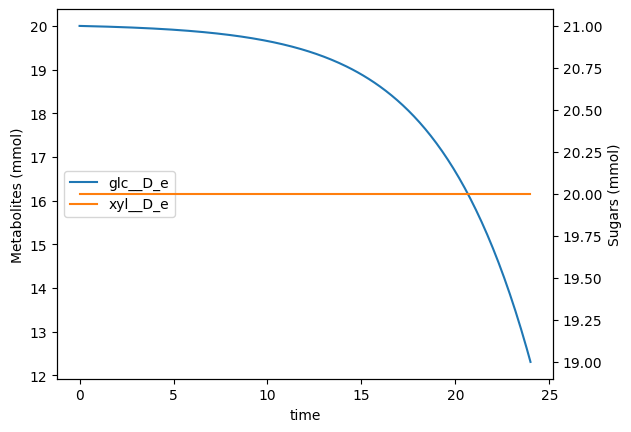

In [38]:
cf.plot_metabolites(sim, ["glc__D_e", "xyl__D_e"], use_molar_amount=True)

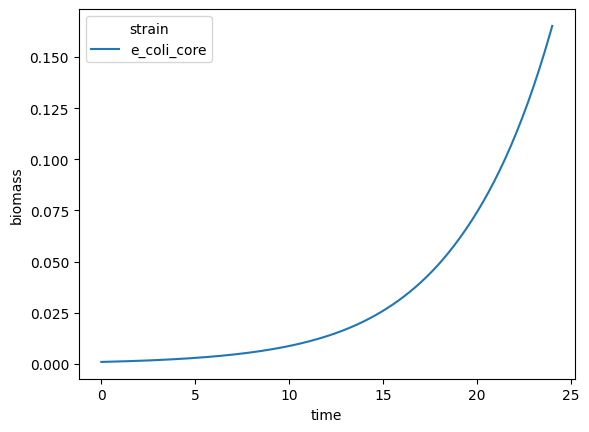

In [39]:
cf.plot_biomass(sim)